# Extreme Multi-label Machine Model

This Jupyter Notebook goes over various methods of multi-label processing using heathcare data

In [ ]:
# Create environemnt if necessary
# conda create -n new environment --file req.txt
#conda install --file req.txt
#conda env update --file req.txt
#pip install -r req.txt
#pip install -U -r req.txt 
#conda create --name XML_LABEL --file req.txt

In [ ]:
# load data
from zipfile import ZipFile
file_name = "data/data.zip"
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
 
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall(path='data')
    print('Done!')

### Baseline Machine Gaussian Naive Bayes Learning Model

In [ ]:
import hickle as hkl
X_train = hkl.load( 'data/X_train.hkl' )
X_test = hkl.load( 'data/X_test.hkl' )
y_test = hkl.load( 'data/y_test.hkl' )
y_train = hkl.load( 'data/y_train.hkl' )

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB

classif_list = []
train_score_list, test_score_list = [], []

# Training
print("Training")
for i in range(len(labels_list)):
    y_train_for_this_ub04 = y_train[:,i]
    new_classifier = GaussianNB()
    new_classifier.fit(X_train, y_train_for_this_ub04)
    classif_list.append(new_classifier)

# Test & display results
print("Test and display results")
for i in range(len(labels_list)):
    classif = classif_list[i]
    train_score = float('{0:.3f}'.format(classif.score(X_train, y_train[:,i])))
    test_score = float('{0:.3f}'.format(classif.score(X_test, y_test[:,i])))
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    print('Detecting {} with {}% accuracy (training {}%)'.format(labels_list[i], 100*test_score, 100*train_score))

predict_train = np.zeros_like(y_train)
predict_test = np.zeros_like(y_test)
for i in range(len(labels_list)):
    classif = classif_list[i]
    predict_train[:,i] = classif.predict(X_train)
    predict_test[:,i] = classif.predict(X_test)
acc_train = 1 - np.sum(np.abs(predict_train - y_train))/(y_train.shape[0]*y_train.shape[1])
acc_test = 1 - np.sum(np.abs(predict_test - y_test))/(y_test.shape[0]*y_test.shape[1])
print('###')
print('Global accuracy: testing {}, training {}'.format(acc_test, acc_train))

well_labeled = 0
for i in range(len(y_train)):
    if np.sum(np.abs(y_train[i,:] - predict_train[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} training samples were well labeled'.format(well_labeled,len(y_train)))

well_labeled = 0
for i in range(len(y_test)):
    if np.sum(np.abs(y_test[i,:] - predict_test[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} testing samples were well labeled'.format(well_labeled,len(y_test)))

# Evidemment, en plus d'être mathématiquement désapprouvée, cette méthode est encombrante:
# imaginez avoir à construire un million de classificateurs ! Ce n'est pas du tout extensible à de la classification extrême

### Deep Extreme Multi-label Learning by Zhang et al
Follwing XML methods in the paper [Deep Extreme Multi-label Learning by Zhang et al](https://arxiv.org/pdf/1704.03718.pdf) and [eXtreme Multilabel Classification Notebook](https://github.com/therhappy/xml-tuto/blob/master/eXtreme%20Multilabel%20Classification%20Notebook%20-%20EN.ipynb). 

![Machine Learning Path Image](https://github.com/Smone5/XML_EHR_LABELS/blob/master/images/labelmatrix.png "Machine Learning Path")

The goal in this section is build an embedded vector of the UB-04, ICD-10, CPT and Modifier labels. This embedded vector will be used to predict the correct label for EHR procedures.


#### Build Labels Embedded Graph
1. Load data
2. Build edges list
3. Convert Label Edges to Embedded Vectors
4. Convert Features to Embedded Vectors

##### 1. Load data

In [71]:
import numpy as np
import hickle as hkl
from scipy.sparse import csr_matrix
X_train = csr_matrix(hkl.load( 'data/X_train.hkl' ))
y_train = hkl.load( 'data/y_train.hkl' )
X_test = csr_matrix(hkl.load( 'data/X_test.hkl' ))
y_test = hkl.load( 'data/y_test.hkl' )
labels_list = hkl.load('data/labels_list.hkl' )

In [68]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [72]:
np.where(y_train[0] == 1)

(array([ 282, 1914, 2423, 3781, 3794, 4486, 8285], dtype=int64),)

In [73]:
Y = np.vstack((y_train,y_test))

In [74]:
np.where(Y[0] == 1)

(array([ 282, 1914, 2423, 3781, 3794, 4486, 8285], dtype=int64),)

In [75]:
# view imported lables
labels_list[0:5]

['10022', '10060', '10120', '10160', '10180']

In [76]:
print("Count of label names: ", len(labels_list))

Count of label names:  8630


In [77]:
# view imported trianing labels
Y[0:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [78]:
#y_train = y_train[0:1000]
print("Labels training rows", Y.shape[0])
print("Labels training columns", Y.shape[1])

Labels training rows 100000
Labels training columns 8630


Note:
The label columns and training columns must be the same size to continue.

##### 2. Build edges list

In [79]:
edges = [] # blank list to hold edges

In [80]:
%%time
# build training edges
for row in Y:
    act = list(np.where(row == 1))
    act = [list(i) for i in act ][0]
    for i in range(len(act)):
        for j in range(len(act)):
            #matrix[i,act[j]] +=1
            if i < j:
                edges.append([act[i],act[j]])
        

Wall time: 11.8 s


In [81]:
edges

[[282, 1914],
 [282, 2423],
 [282, 3781],
 [282, 3794],
 [282, 4486],
 [282, 8285],
 [1914, 2423],
 [1914, 3781],
 [1914, 3794],
 [1914, 4486],
 [1914, 8285],
 [2423, 3781],
 [2423, 3794],
 [2423, 4486],
 [2423, 8285],
 [3781, 3794],
 [3781, 4486],
 [3781, 8285],
 [3794, 4486],
 [3794, 8285],
 [4486, 8285],
 [283, 6113],
 [283, 1598],
 [283, 1897],
 [283, 1908],
 [283, 6363],
 [1598, 1897],
 [1598, 1908],
 [1598, 6363],
 [1897, 1908],
 [1897, 6363],
 [1908, 6363],
 [283, 7972],
 [283, 8457],
 [7972, 8457],
 [283, 2011],
 [283, 2052],
 [283, 2186],
 [283, 2412],
 [283, 6203],
 [283, 8624],
 [2011, 2052],
 [2011, 2186],
 [2011, 2412],
 [2011, 6203],
 [2011, 8624],
 [2052, 2186],
 [2052, 2412],
 [2052, 6203],
 [2052, 8624],
 [2186, 2412],
 [2186, 6203],
 [2186, 8624],
 [2412, 6203],
 [2412, 8624],
 [6203, 8624],
 [373, 5309],
 [290, 6179],
 [290, 6438],
 [6179, 6438],
 [867, 1824],
 [867, 2838],
 [867, 4215],
 [867, 6121],
 [1824, 2838],
 [1824, 4215],
 [1824, 6121],
 [2838, 4215],
 [2838

In [82]:
'''
# code for converting the numerical number back to original label for checking.
label_dict = {}
for i in range(len(labels_list)):
    label_dict[i] = labels_list[i]

for i in range(len(edges2)):
    val1 = edges2[i][0]
    val2 = edges2[i][1]
    edges2[i][0] = label_dict[val1]
    edges2[i][1] = label_dict[val2]
'''

'\n# code for converting the numerical number back to original label for checking.\nlabel_dict = {}\nfor i in range(len(labels_list)):\n    label_dict[i] = labels_list[i]\n\nfor i in range(len(edges2)):\n    val1 = edges2[i][0]\n    val2 = edges2[i][1]\n    edges2[i][0] = label_dict[val1]\n    edges2[i][1] = label_dict[val2]\n'

In [83]:
# convert train edges to edge list file for Deepwalk

import networkx as nx
G=nx.Graph()
for edge in edges:
        G.add_edge(edge[0], edge[1])
        
# save as edge list file
with open('deepwalk/graphs/edges.edgelist', 'w') as f:
    for edge in G.edges():
        f.write("{} {}\n".format(edge[0] ,edge[1]))

##### Analyze the graph in GraphCrunch 2 or Gephi
At this point you could visulize the graph in GraphCrunch 2 or Gephi
+ [GraphCrunch 2](http://www0.cs.ucl.ac.uk/staff/natasa/graphcrunch2/index.html)
+ [Paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-24)

##### 3. Convert Label Edges to Embedded Vectors
There are a few methods to convert a network graph each node into a network as a low-dimensional feature vector.

1. [Deepwalk](https://github.com/phanein/deepwalk)
2. [Node2Vec](https://snap.stanford.edu/node2vec/)
3. [Struct2Vec](https://github.com/leoribeiro/struc2vec)
4. Graphlets

Due a paper from Shawn Gu and Tijana Milenković called [*Graphlets versus node2vec and struc2vec in the task of network alignment*](https://www.groundai.com/project/graphlets-versus-node2vec-and-struc2vec-in-the-task-of-network-alignment/), in certain situations a graphlet could outperform Node2Vec or Struct2Vec to quantify node similarities.

However due to time constraints, Deepwalk will be used in this method

*Note* :To use Deepwalk, you must use a Python 2.7 environment at the time of writing this

###### Deepwalk
To run Deepwalk you must run these line while in the folder *deepwalk*. This process can take a while.

deepwalk --input graphs/edges.edgelist --number-walks 150 --representation-size 300 --window-size 2 --workers 2 --output graphs/edges.embeddings

##### 4. Convert Features to Embedded Vectors

In [14]:
# load embeddings
import gensim
embedding =gensim.models.KeyedVectors.load_word2vec_format('deepwalk/graphs/edges.embeddings')

C:\Users\amelton005\AppData\Local\Continuum\anaconda3\envs\Standard Analytics\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [15]:
# load vectors from embeddings

V_embed = embedding.vectors

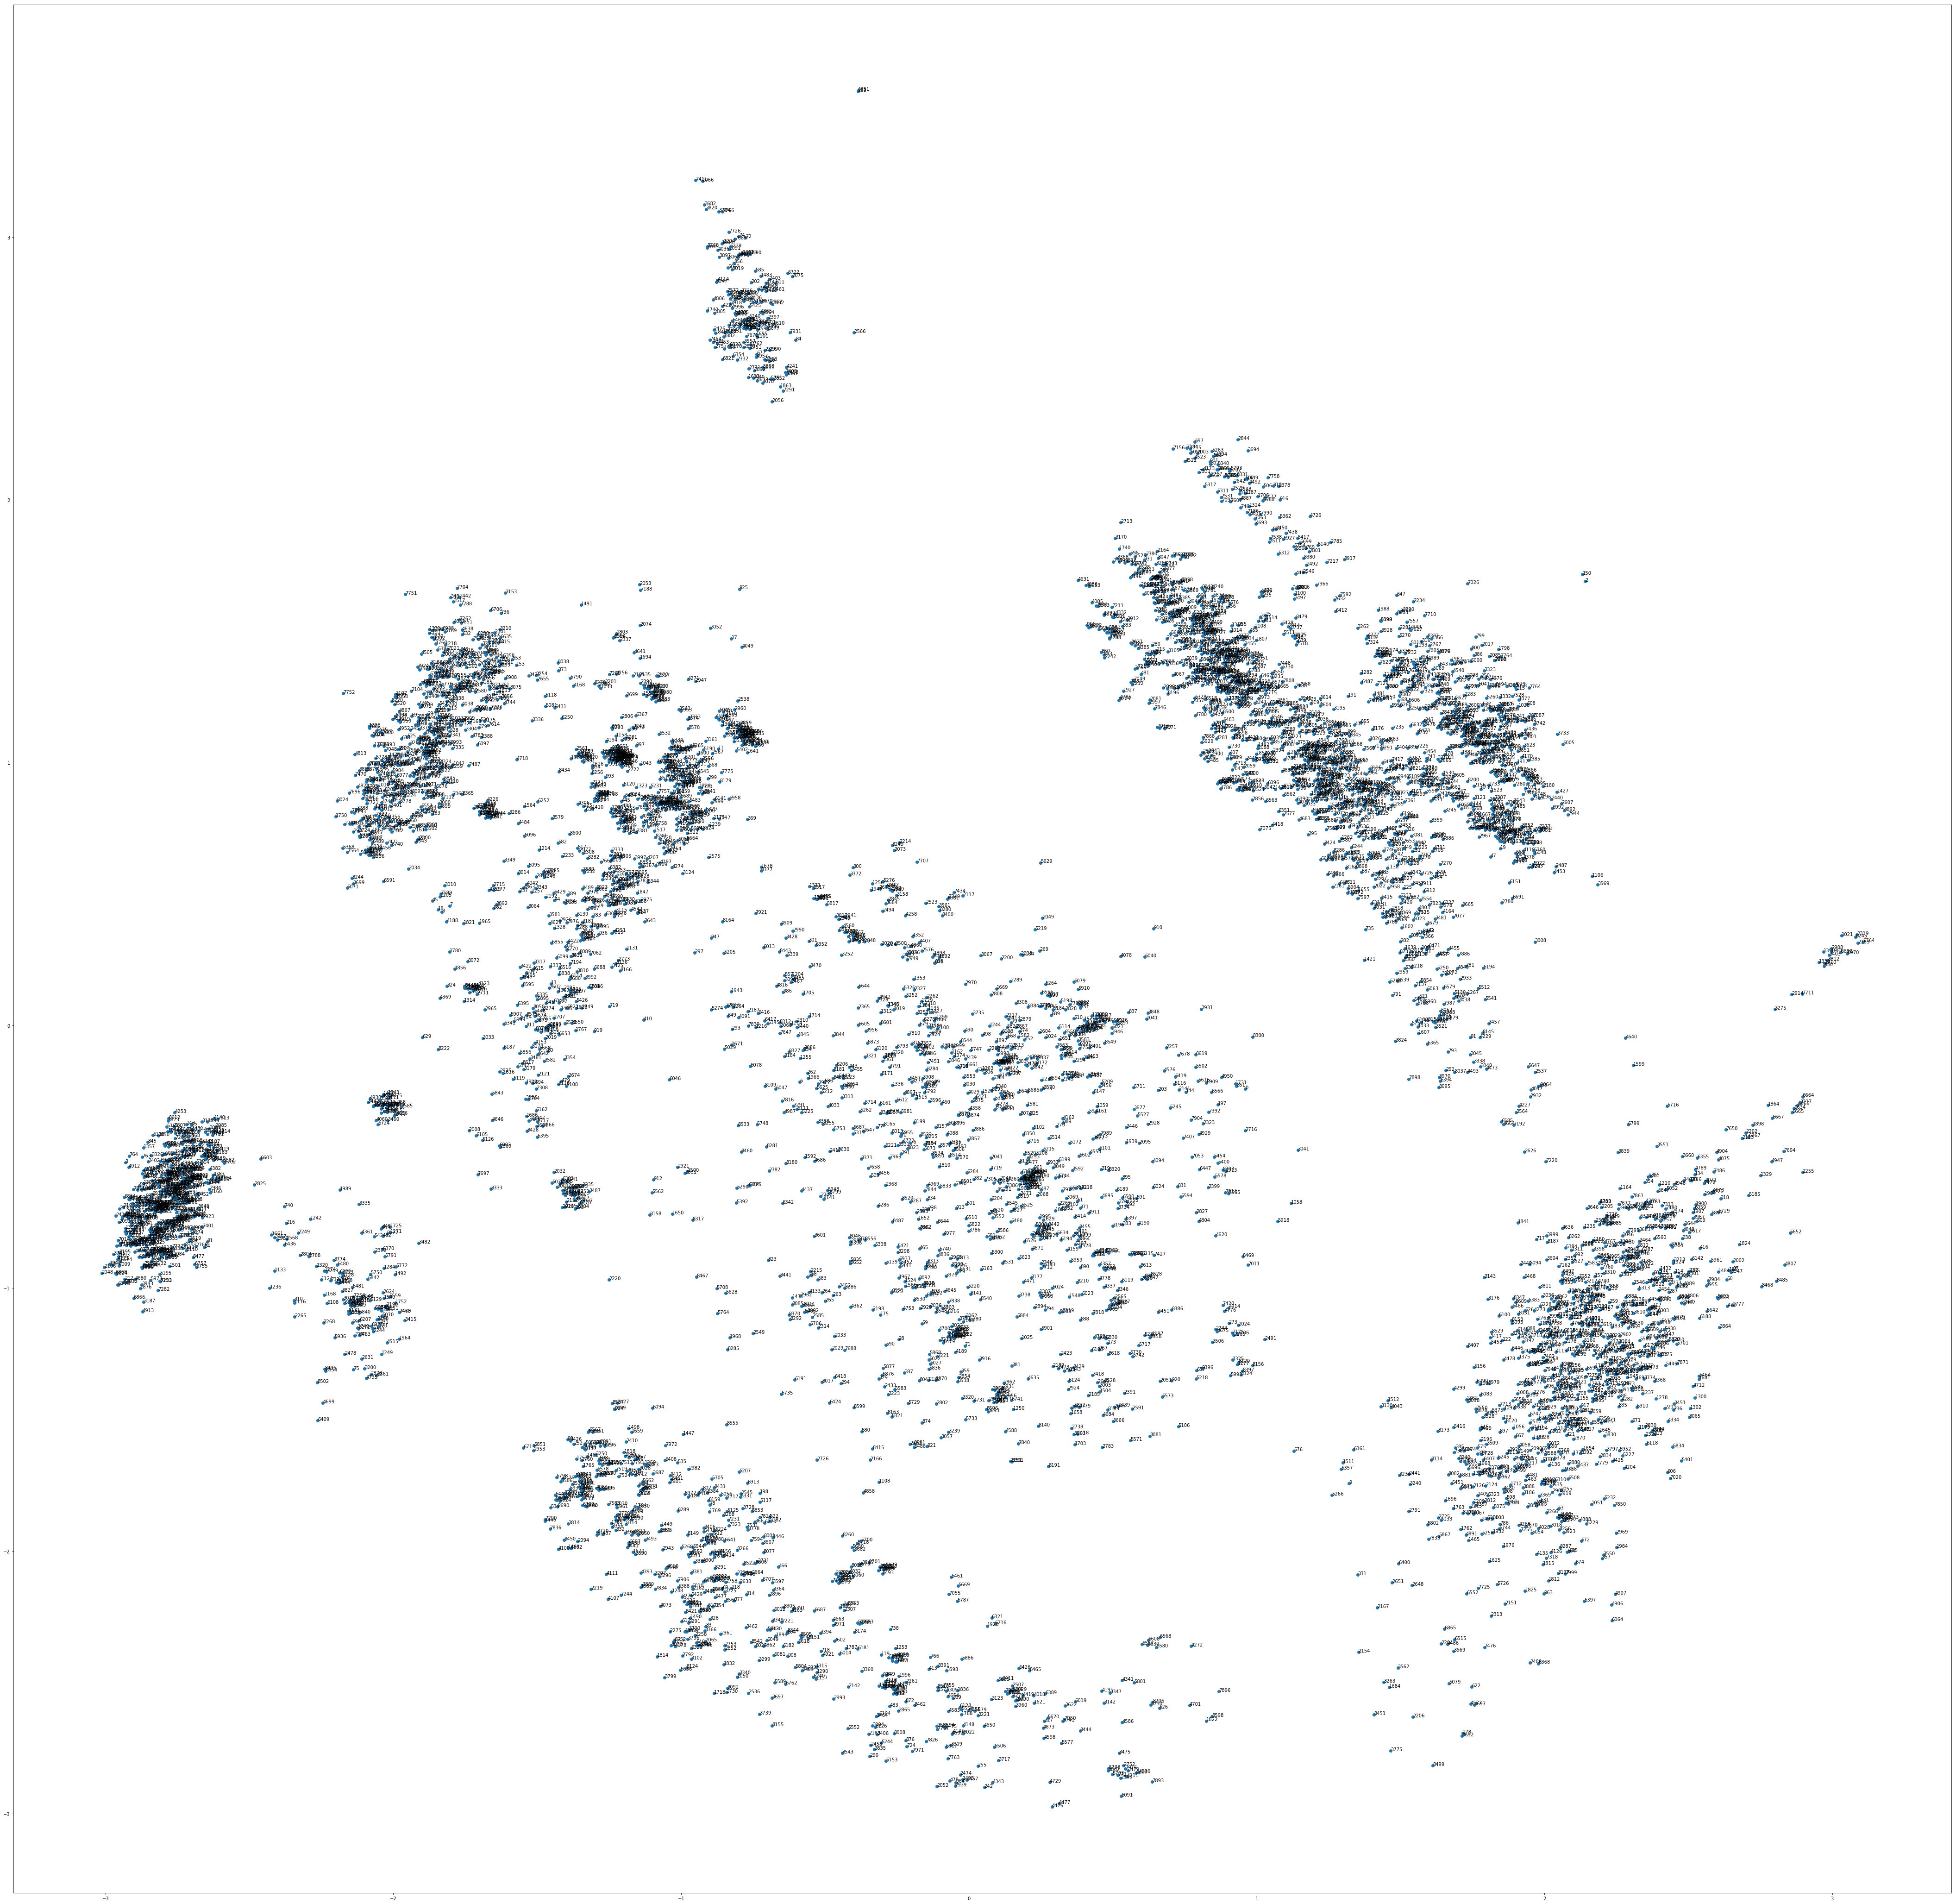

In [16]:
# Plot training embedded vectors into one dimensional graph

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

pca = PCA(n_components=2)
result = pca.fit_transform(V_embed)
# create a scatter plot of the projection
plt.figure(figsize=(75,75))
plt.scatter(result[:, 0], result[:, 1])
words = list(embedding.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.savefig("images/PCA_graph.png")
plt.show()

Now we need to project the original label matrix to a new matrix including the embedded vectors.

In [84]:
print("Rows: ", V_embed.shape[0])
print("Columns: ",V_embed.shape[1])

Rows:  6464
Columns:  300


The embedded vector is 6,088 rows and 300 columns. Each row represents a node and its associated vectors. The orginal label matrix is 67,000 rows and 8,630 columns. Each rows represents a 1 if a label should exists or 0 if one doesn't.

In [85]:
import pandas as pd
labels_df = pd.DataFrame(data=y_train)
labels_df.head()

,0,1,2,3,4,5,6,7,8,9,...,8620,8621,8622,8623,8624,8625,8626,8627,8628,8629
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [86]:
for col in labels_df:
    labels_df[col] = np.where(labels_df[col] == 0, 0, col)

In [87]:
labels_df.head()

,0,1,2,3,4,5,6,7,8,9,...,8620,8621,8622,8623,8624,8625,8626,8627,8628,8629
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8624,0,0,0,0,0


In [88]:
fY = []
for index, row in labels_df.iterrows():
    #print(index)
    index_vals = np.where(labels_df.loc[index] > 0)[0].tolist()
    #print(index_vals)
    matrix = 1
    for val in index_vals:
        try:
            vector = embedding[str(val)]
            matrix = vector * matrix
        except KeyError:
            pass
        
    matrix = (1/len(index_vals))*matrix    
    fY.append(matrix)

In [89]:
from keras import backend as K

from keras.layers import Input
from keras import regularizers
features_input = Input(shape=(287,), dtype='float')

from keras.layers import Dense, Lambda, Dropout, BatchNormalization
from keras import optimizers

x = Dense(512, activation='relu', name='fc1', kernel_regularizer=regularizers.l2(0.01))(features_input)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dropout(0.25)(x)
x = Dense(300, activation='linear')(x)
predictions = BatchNormalization()(x)


#l2 = Lambda(lambda x: K.l2_normalize(x, axis=1))(predictions)

from keras.models import Model
model = Model(inputs=features_input, outputs=predictions)

model.compile(optimizer=optimizers.Adam(lr=0.015, decay=0.0005),
              loss='mean_squared_error')


In [90]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 287)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               147456    
_________________________________________________________________
fc2 (Dense)                  (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               153900    
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
Total params: 565,212
Trainable params: 564,612
Non-trainable params: 600
_________________________________________________________________


In [91]:
print("Rows: ", X_train.shape[0])
print("Columns: ",X_train.shape[1])

Rows:  67000
Columns:  287


In [92]:
fY2 = np.asarray(fY)

In [93]:
print("Rows: ", fY2.shape[0])
print("Columns: ",fY2.shape[1])

Rows:  67000
Columns:  300


loss: 0.3210 - val_loss: 1.347 <br>
loss: 0.0018 - val_loss: 0.0019

In [94]:
'''
Train the deep neural network shown in Figure 1 to obtain
the mapping from original feature vector set X to embedded
feature vector set fX = { fx }
'''

model.fit(X_train, fY2, epochs=5, batch_size=32, validation_split=0.1, shuffle=True, class_weight='auto')

Train on 60300 samples, validate on 6700 samples
Epoch 1/5
60300/60300 [==============================] - 32s 528us/step - loss: 0.0224 - val_loss: 0.0020
Epoch 2/5
60300/60300 [==============================] - 40s 664us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 3/5
60300/60300 [==============================] - 42s 702us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 4/5
60300/60300 [==============================] - 48s 794us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 5/5
60300/60300 [==============================] - 52s 867us/step - loss: 0.0018 - val_loss: 0.0020


In [95]:
fX = model.predict(X_train)

In [96]:
fX[0]

array([ 9.84266982e-04, -2.98773195e-03, -1.01213288e-02, -7.69940112e-03,
       -1.99118303e-03,  1.22818043e-02, -4.39534429e-03,  9.68977902e-03,
        2.68068723e-03, -4.97032097e-03, -4.04642476e-03, -5.55552728e-03,
       -6.87758159e-03,  1.63717568e-03,  5.45562850e-03, -6.50455011e-03,
       -3.24080442e-03, -2.48696120e-03, -2.01155338e-03, -6.42413693e-03,
       -8.55379179e-03, -1.94316742e-03, -4.42951248e-04, -1.60292245e-03,
        3.35646793e-03,  3.76881310e-03,  3.64921568e-03, -2.56226421e-03,
        7.12339580e-03,  6.99823548e-04, -8.40668008e-03, -3.61026818e-04,
        4.58785426e-03, -2.66783219e-03, -1.88837328e-03,  5.08954935e-03,
        6.15025032e-03,  2.78089079e-03,  7.40997901e-04, -3.31329997e-03,
       -4.61371895e-03,  1.18818192e-03,  5.89998439e-03, -1.84831268e-04,
        1.15046091e-02, -3.09035787e-03,  2.28380947e-03, -4.88816481e-03,
       -4.89631435e-03,  1.98743911e-03,  8.65258649e-03,  2.86883838e-03,
       -3.27047659e-03, -

-0.39727506 <br>
-0.4063257

In [31]:
diff = np.sum(fY2[1] - fX[1])
diff

-0.3976076

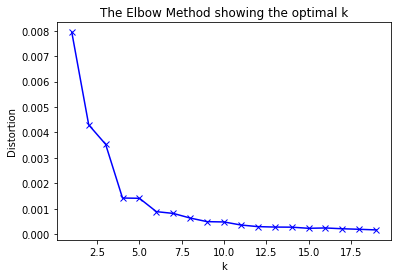

In [32]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# k-means elbow method: The elbow method finds the optimal value for k (#clusters).
# https://pythonprogramminglanguage.com/kmeans-elbow-method/

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(fX)
    kmeanModel.fit(fX)
    distortions.append(sum(np.min(cdist(fX, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / fX.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

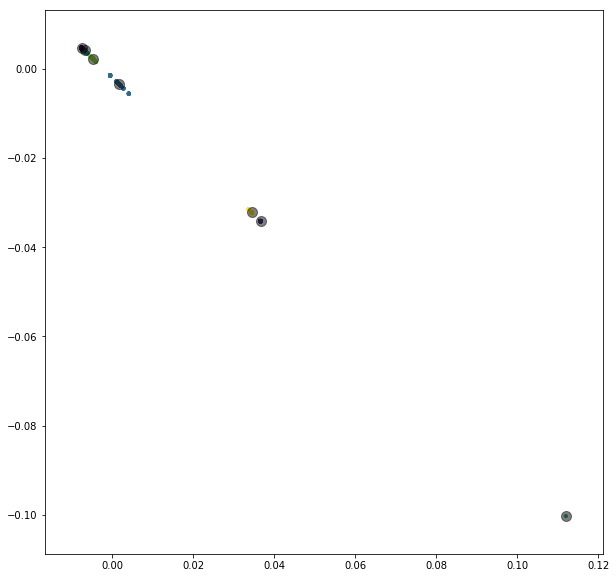

In [51]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# create kmeans object
kmeans = KMeans(n_clusters=7, n_jobs=-1, n_init=8, max_iter=300)

# fit kmeans object to data
kmeans.fit(fX)

#  Partition fX into Z1, . . . ,Zm
Z = kmeans.fit_predict(fX)

# save new clusters for chart
plt.figure(figsize=(10,10))
plt.scatter(fX[:, 0], fX[:, 1], c=Z, s=10, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);

### Prediction

In [35]:
X_test = hkl.load( 'data/X_test.hkl' )

# first get its low-dimensional feature representation
fX_test = model.predict(X_test)

In [38]:
from sklearn.neighbors import NearestNeighbors
Z_neighbors = NearestNeighbors(n_neighbors=5, metric='cosine').fit(fX_test)

In [43]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,RVU,PE RVU,PE RVU.1,TOTAL,TOTAL.1,AMOUNT,AMOUNT.1,AMOUNT.2,FACILITY PRICE,NON-FACILTY PRICE
59428,29,5538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,4.0,3.0,3.0,2.0,4.0,0.0,4.0,0.0,1.0
34957,24,8303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,4.0,3.0,3.0,2.0,4.0,0.0,4.0,0.0,1.0
4264,28,6512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,4.0,3.0,3.0,2.0,4.0,0.0,4.0,0.0,1.0
53791,23,5762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,4.0,3.0,3.0,2.0,4.0,0.0,4.0,0.0,1.0
82114,10,5707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,4.0,3.0,3.0,2.0,4.0,0.0,4.0,0.0,1.0


In [50]:
X_train.as_matrix() @ fX

C:\Users\amelton005\AppData\Local\Continuum\anaconda3\envs\Standard Analytics\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


ValueError: shapes (67000,287) and (67000,300) not aligned: 287 (dim 1) != 67000 (dim 0)

In [53]:
X_train.toarray() @ fX.T

AttributeError: 'DataFrame' object has no attribute 'toarray'

In [39]:
Z_neighbors

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm='brute', n_jobs=-1)
knn.fit(fY2, y_train)

In [ ]:
Kx = knn.kneighbors(fX_test,n_neighbors=5, return_distance=True)

In [ ]:
knn.predict(Kx)

In [ ]:
Kx[0,1]

In [ ]:
#y_train[32444,:]

In [ ]:
number_of_samples = Kx.shape[0]
number_of_samples

In [ ]:
labels = np.zeros((number_of_samples, y_train.shape[1]))
#labels

In [ ]:
for j in range(5):
    labels[0, :] += y_train[Kx[0,j],:]

In [ ]:
#labels[0, :]

In [ ]:
for j in range(labels.shape[1]):
            if labels[0,j]: labels[0,j] = 1

In [ ]:
#labels[0]

In [ ]:
np.array_equal(y_test[0,:] , labels[0,:])

##### 4. Build X path for features